# Email assistant
Developing the email assistant. This is a more complex app with lots of back-and-forth. This demonstrates:

1. How to move in/out of program control -> user control
2. How to process inputs at multiple points through the process
3. How to involve multi-shot modeling with an LLM

Note this can easily be extended. While the user provides feedback, for a more complex draft, a multi-shot agent with a "editor" agent and a "writer" agent could interact until the editor is happy. For an email this is overkill, but for more complex narratives this could be valauble.

# The Application

We're modeling this as a multi-shot model. No sane person would trust GPT-x to respond on their behalf, 
but it can be quite valuable in helping automate the process of responding to an email and deciding how to respond.
There are a few interaction points:

1. Initially, the user provides an email and response instructions (note this should probably be changed to be a chain of emails)
2. The LLM has the option to ask a set of clarifying questions that the user can then respond to
3. The user then provides feedback. If feedback is empty, the LLM will return a result

This demonstrates how to use Burr to move in/out of more complex flows. 

First, we instantiate/visualize the application. To see the code, see [application.py](application.py).

In [1]:
from application import application as email_assistant_application

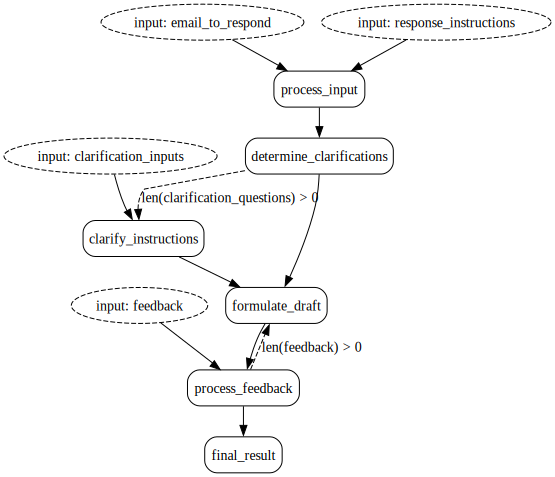

In [2]:
app = email_assistant_application()
app.visualize(include_conditions=True, include_state=False)

# Telemetry

To see the application "think", let's open up telemetry. Before running the next cell ensure `burr` is run and you have the UI open. Then navigate to the following link:

In [3]:
from IPython.display import Markdown
url = f"[Link to UI](http://localhost:7241/project/demo:email_assistant/{app.uid})"
Markdown(url)

[Link to UI](http://localhost:7241/project/demo:email_assistant/a053f4c9-1973-4ef1-94ac-b0c2db19be7f)

# Prompt the machine

I'm going to be asking that the LLM help me turn around a cold-call. We get a lot of these -- I'm curious if it can help me leverage this for OS promotion! Note that this is a dubious (at best) use-case, but hey, these emails are likely written by AI as well.

Change these to your use-case:

In [4]:
EMAIL = """Hi Elijah,

I hope you are well.

I am connecting again to know your thoughts on my previous email regarding DAGWorks's feature in our forthcoming 8th annual edition on Artificial Intelligence. I want to explain how this recognition will help you attain more qualified prospects and increase your client base.

Our previous clients have seen a visible increase in prospect conversion rate by effectively utilizing this recognition. We would like DAGWorks to also leverage this recognition and witness impressive results.

Please inform me of your availability for a quick chat. I look forward to your kind response.


Regards,
Someone"""

INSTRUCTIONS = """I get a bunch of these emails and usually ignore them. I don't want to pay 
(or really engage) but I want to see if they can help promote our tooling, 
particularly the OS libraries Hamilton and Burr, which are tools for AI practitioners. 
Let's see if we can turn this cold-call around.
"""

# Prompting for user-response

During execution, there are several points at which the user provides additional feedback. This is:

1. When the LLM has questions for the user (`request_answers`)
2. When the LLM needs feedback (`request_feedback`)

These are functions we'll call later to ensure you can interact with the LLM. In a web-service this would be the point that we go back and forth (E.G. stop before), and would be replaced by endpoints. We're just using `input()` here as its the simplest way to get user input.

We are going to run this until we get to the `final_result` step. We're going to have two stopping conditions:

- `halt_before`: `clarify_instructions` and `process_feedback` -- these are the two steps that require input. We want to stop before so we can feed input to the user. We will call the above functions.
- `halt_after` : `final_result` -- this means we're done! We can just print out the draft.

We will break at `final_result`, as the state machine is complete.

In [5]:
def request_answers(questions):
    """Requests answers from the user for the questions the LLM has"""
    answers = []
    print("The email assistant wants more information:\n")
    for question in questions:
        answers.append(input(question))
    return answers

def request_feedback(draft):
    """Requests feedback from the user for a draft"""
    print( 
        f"here's a draft!: \n {draft} \n \n What feedback do you have?",
        "If you have no feedback then we'll finish it up."
    )
    return input("Write feedback or leave blank to continue (if you're happy)")

inputs = {
    "email_to_respond" : EMAIL,
    "response_instructions" : INSTRUCTIONS
}
while True:
    action, result, state = app.run(
        halt_before=["clarify_instructions", "process_feedback"], 
        halt_after=["final_result"],
        inputs=inputs
    )
    if action.name == "clarify_instructions":
        questions = state["clarification_questions"]
        answers = request_answers(questions)
        inputs = {
            "clarification_inputs" : answers
        }
    if action.name == "process_feedback":
        feedback = request_feedback(state["current_draft"])
        inputs = {"feedback" : feedback}
    if action.name == "final_result":
        print("final result is:", state["current_draft"])
        break

The email assistant wants more information:



1. Can you please provide some specific features or achievements about the Hamilton and Burr libraries that you would like highlighted? Wide usage, large number of enterprise customers, pluggable, lightweight
2. Are there any particular benefits or testimonials from users of Hamilton and Burr libraries that we can share? let's hold off on that
3. What level of engagement, if any, are you willing to have with this organization beyond this instance of promotion? let's avoid taht


here's a draft!: 
 Subject: Re: DAGWorks's Feature in Your 8th Annual Edition on Artificial Intelligence

Dear [Someone],

Thank you for your last email and the opportunity to feature DAGWorks in your forthcoming 8th annual edition on Artificial Intelligence. Your outreach is appreciated and has certainly sparked some interest given the proven positive results you've suggested.

In the spirit of establishing a mutual understanding, we're particularly proud of our standout tools Hamilton and Burr. Both libraries have been recognized for their wide usage, tailor-made features for enterprises, and their pluggability and lightweight nature. This recognition has been supported by a large number of enterprise customers, cementing their position as formidable tools in the AI field.

Without necessarily engaging in a full-fledged partnership, it would be interesting to consider how these libraries could be highlighted in your edition. This could help promote our tooling even further and potent

Write feedback or leave blank to continue (if you're happy) Make it slightly less formal


here's a draft!: 
 Subject: Re: DAGWorks's Feature in Your 8th Annual Edition on Artificial Intelligence

Hey [Someone],

Thanks for reaching out. It's good to hear you're interested in featuring DAGWorks in your upcoming AI edition. You've definitely caught our attention with the promise of those impressive results and I'd like to explore the terms a bit before committing to anything.

Hamilton and Burr - our pride and joy - are two OS libraries that have established a pretty solid name in the AI world. They're widely used, customizable, lightweight, and packed with enterprise features. True gems for AI practitioners!

I’m curious about the potential to put a spotlight on these two in your edition. What better way to get the word out, right? But let's keep it real, while I fancy the idea of a wider audience, we're playing it cautiously and not currently looking to splash any cash. 

That being said, I'm all ears to hear more on how this feature might benefit DAGWorks, especially with 

Write feedback or leave blank to continue (if you're happy) 


final result is: Subject: Re: DAGWorks's Feature in Your 8th Annual Edition on Artificial Intelligence

Hey [Someone],

Thanks for reaching out. It's good to hear you're interested in featuring DAGWorks in your upcoming AI edition. You've definitely caught our attention with the promise of those impressive results and I'd like to explore the terms a bit before committing to anything.

Hamilton and Burr - our pride and joy - are two OS libraries that have established a pretty solid name in the AI world. They're widely used, customizable, lightweight, and packed with enterprise features. True gems for AI practitioners!

I’m curious about the potential to put a spotlight on these two in your edition. What better way to get the word out, right? But let's keep it real, while I fancy the idea of a wider audience, we're playing it cautiously and not currently looking to splash any cash. 

That being said, I'm all ears to hear more on how this feature might benefit DAGWorks, especially with re